In [6]:
import re
import math
from collections import Counter
from functools import reduce 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Creating Naive Bayes classifier

In [7]:
# I reused some of the code from problem set 2 to make naive Bayes classifiers for Reddit comments 
# in a given community based on their valence (positive or negative net score).

pos_comm_token_counts = Counter() #token counts for positive comments
pos_comm_count = 0 #number of positive comments
neg_comm_token_counts = Counter() #token counts for negative comments
neg_comm_count = 0 #number of negative comments

token_pattern = re.compile("\w+")

h_pos_test_set = []
h_neg_test_set = []

In [8]:
with open("hillaryclinton_pos_comms.txt", "r")as inf:
    #create positive comment and token counts
    pfile = inf.readlines()
    testing_lim = len(pfile) - (len(pfile) * .2)
    for line in pfile: 
        if pos_comm_count >= testing_lim: #reserve 20% for testing
            h_pos_test_set.append(line)
        else: 
            pos_comm_token_counts.update(token_pattern.findall(line))
            pos_comm_count += 1
        
  
with open("hillaryclinton_neg_comms.txt", "r")as infn:
    #create negative comment and token counts
    nfile = infn.readlines()
    print (len(nfile))
    testing_lim = len(nfile) - (len(nfile) * .2)
    print(len(nfile) - (len(nfile) * .2))
    for line in nfile:
        if neg_comm_count >= testing_lim: #reserve 20% for testing
            
            h_neg_test_set.append(line)
        else:
            neg_comm_token_counts.update(token_pattern.findall(line))
            neg_comm_count += 1

1074
859.2


In [9]:
# #write test arrays to files to feed into classify()
# with open("hillaryclinton_test_pos_comms.txt", "w") as out: 
#     for x in h_pos_test_set:
#         out.write(x)
        
# with open("hillaryclinton_test_neg_comms.txt", "w") as out: 
#     for x in h_neg_test_set:
#         out.write(x)

In [10]:
P_pos = pos_comm_count/(pos_comm_count + neg_comm_count)
print (P_pos) #.78 because there are more positive comments than negative
print (pos_comm_count)
print (neg_comm_count)

0.7862823061630219
3164
860


In [11]:
num_pos_tokens = sum(pos_comm_token_counts.values())
num_neg_tokens = sum(neg_comm_token_counts.values())

In [12]:
both_counts = pos_comm_token_counts + neg_comm_token_counts
both_tokens = sum(both_counts.values()) #total tokens across both pos and neg comments
vocabulary_size = len(both_counts)
print(vocabulary_size)

16814


In [13]:
#smoothed probabilities to more gracefully handle words not in vocabulary
def smoothed_word_log_prob(word, counter, summ):
    # smoothed log probability that [word] will occur given valence token counts [counter] 
    # and valence token total [summ] 
    return math.log((counter[word] + 1)/(summ + vocabulary_size))

def smoothed_comm_log_prob(phrase, counter, summ):
    #smoothed log probability that [phrase] will occur given valence token counts [counter] 
    # and valence token total [summ] 
    phrase_tokens = token_pattern.findall(phrase)
    phrase_prob = reduce((lambda x, y: x+y), [smoothed_word_log_prob(token, counter, summ) for token in phrase_tokens])  
    return phrase_prob

In [14]:
print ("*pos word probs*")
print(smoothed_word_log_prob("Bernie", pos_comm_token_counts, num_pos_tokens))
print ("\n*neg word probs*")
print(smoothed_word_log_prob("Bernie", neg_comm_token_counts, num_neg_tokens))
#maybe try slurs? tried so far: sucks, wrong, bernie, maga

*pos word probs*
-6.225611279407289

*neg word probs*
-6.2066919561965435


In [15]:
log_P_pos = math.log(pos_comm_count/(pos_comm_count + neg_comm_count)) #log probability that any given comment is pos
log_P_neg = math.log(neg_comm_count/(pos_comm_count + neg_comm_count)) #log probability that any given comment is neg

def classifier_score(comment):
    # returns the classifier score for a string [comment]. the score is the log of the ratio of 
    # the probability of [comment] scoring positively to the probability of [comment] scoring negatively.
    log_P_words_given_pos = smoothed_comm_log_prob(comment, pos_comm_token_counts, num_pos_tokens)
    log_P_words_given_neg = smoothed_comm_log_prob(comment, neg_comm_token_counts, num_neg_tokens)
    return (log_P_words_given_pos + log_P_pos) - (log_P_words_given_neg + log_P_neg)

# to interpret classifier score: if positive, classifier thinks [comment] is more likely to score positively than 
# negatively. if negative,  [comment] more likely to score negatively than positively
# the higher the positive number, the more likely the classifier thinks [comment] is to score positively, 
# and the lower the negative number, the more likely the classifier thinks [comment] is to score negatively

In [16]:
def classify(sub):
    #Classify all sampled comments for subreddit [sub]. Return an array containing: an array of classifier scores 
    #for positive comments, an array of classifier scores for negative comments, and four arrays containing comments 
    #with positive scores greater than 20, less than -20, negative scores greater than 20, less than -20 respectively.
    p_greater20 = []
    p_lessneg20 = [] 
    with open(sub + "_pos_comms.txt", "r")as inf:
        pfile = inf.readlines()
        classified_p = np.zeros(len(pfile))
        for i, line in enumerate(pfile):
            if line.strip() == "": 
                next
            else:
                c_score = classifier_score(line)
                classified_p[i] = c_score
                if c_score > 20:
                    p_greater20.append((i, line))
                if c_score < -20:
                    p_lessneg20.append((i, line))

    n_greater20 = []
    n_lessneg20 = []
    with open(sub + "_neg_comms.txt", "r")as inf:
        nfile = inf.readlines()
        classified_n = np.zeros(len(nfile))
        for i, line in enumerate(nfile): 
            if line.strip() == "": 
                next
            else:
                c_score = classifier_score(line)
                classified_n[i] = classifier_score(line)
                if c_score > 20:
                    n_greater20.append((i, line))
                if c_score < -20:
                    n_lessneg20.append((i, line))
    return [classified_p, classified_n, p_greater20, p_lessneg20, n_greater20, n_lessneg20]

#I included the arrays with "outlier" comments in case it would be interesting to look at the content of those comments. 

just to see, i try the classifier on the training set
(should i try it on other posts from hillary, from earlier/later to see if its more accurate on those than ones from other subs?)

## model validation

In [17]:
#checking how the model performs on trained data
classified_hillary = classify("hillaryclinton")
classified_hillary_p = classified_hillary[0]
classified_hillary_n = classified_hillary[1]

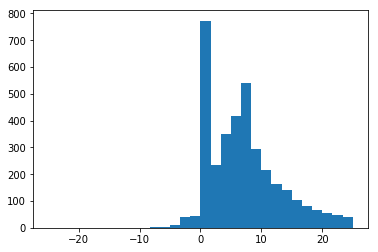

In [18]:
plt.hist(classified_hillary_p, bins=30, range=[-25,25])
plt.show()

good

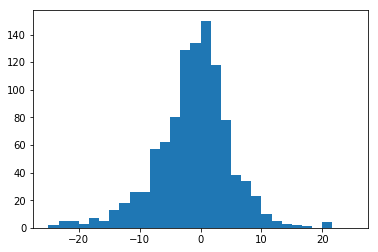

In [19]:
plt.hist(classified_hillary_n, bins=30, range=[-25,25])
plt.show()

not so good

In [20]:
#checking how model performs on test data
classified_hillary_t = classify("hillaryclinton_test")
classified_hillary_p_t = classified_hillary_t[0]
classified_hillary_n_t = classified_hillary_t[1]

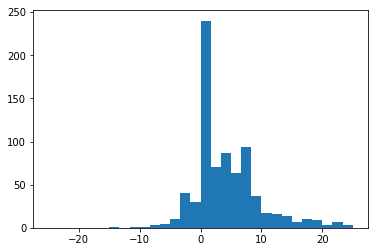

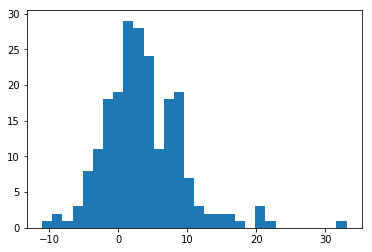

In [21]:
plt.hist(classified_hillary_p_t, bins=30, range=[-25,25])
plt.show()
plt.hist(classified_hillary_n_t, bins=30,)
plt.show()

performed pretty well on positively rated comments. horribly on negatively rated comments

In [22]:
p_lab = [1 for x in range(len(classified_hillary_p_t))]
n_lab = [-1 for x in range(len(classified_hillary_n_t))]
p_lab.extend(n_lab)
true_labels_p = np.array(p_lab)
pt_lab = [1 if x >= 0 else -1 for x in classified_hillary_p_t]
nt_lab = [1 if x >= 0 else -1 for x in classified_hillary_n_t]
pt_lab.extend(nt_lab)
predictions = np.array(pt_lab)

Text(0.5, 1.0, 'Hillary classifier validation')

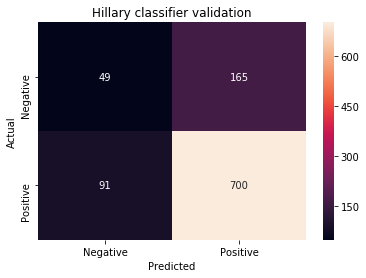

In [23]:
#making a heatmap to see how I did
ticklabels = ['Negative', 'Positive']
sns.heatmap(confusion_matrix(true_labels_p, predictions), annot=True, fmt='d', xticklabels=ticklabels, yticklabels=ticklabels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Hillary classifier validation')

In [24]:
true_pos = 700
true_neg = 49
false_pos = 165
false_neg = 91
precision = true_pos/(true_pos + false_pos)
recall = true_pos/(true_pos + false_neg)
f1 = 2*((precision*recall)/(precision+recall)) # a measure of accuracy; integrating precision and recall
print("for positives")
print("precision: " + str(precision))
print("recall: " + str(recall))
print ("f1(accuracy): " + str(f1))

for positives
precision: 0.8092485549132948
recall: 0.8849557522123894
f1(accuracy): 0.8454106280193238


In [25]:
precision = true_neg/(true_neg + false_neg)
recall = true_neg/(true_neg + false_pos)
f1 = 2*((precision*recall)/(precision+recall)) # a measure of accuracy; integrating precision and recall
print("for negatives")
print("precision: " + str(precision))
print("recall: " + str(recall))
print ("f1(accuracy): " + str(f1))

for negatives
precision: 0.35
recall: 0.22897196261682243
f1(accuracy): 0.2768361581920904


confirming with numbers what we saw in the histograms: pretty good for positive comments (about 85% correct), dismal for negative comments (about 30% correct). These numbers are pretty similar between the Hillary and Donald classifiers as well. It may be a factor of how much smaller the negatively scored comments set (~1000) is compared with the positively scored comments (~4000).

In [26]:
#neg scored comment in the_donald
d_neg = "Just because there is noise in our models doesnt mean we cant estimate a trend How accurately we can predict short term weather doesnt really have anything to do with whether or not we can predict an overall long term trend"
print("negatively-scored comment in /r/the_donald:")
print("\"" + d_neg + "\"")
print("classifier score:")
print(classifier_score(d_neg))

print("")

#pos scored comment in the_donald
d_pos = "the People of the United States in Order to form a more perfect Union establish Justice insure domestic Tranquility provide for the common defence promote the general Welfare and secure the Blessings of Liberty to ourselves and our Posterity do ordain and establish this Constitution for the United States of America"
print("positively-scored comment in /r/the_donald:")
print("\""+ d_pos + "\"")
print("classifier score:")
print(classifier_score(d_pos))


#I'm also assuming that it would make sense for negatively scoring comments in a polit sub to rate positively in
#the opposing polit sub, but that's not necessarily true

#one of the problems is that they talk about the same issues but have diff takes on it. they're discussing similar 
#concepts so maybe the worsd theyre using are similar too. 
#on the other hand though the language is different, exact word choice is different too. Maybe that's what my 
#classifier could help pick out.


negatively-scored comment in /r/the_donald:
"Just because there is noise in our models doesnt mean we cant estimate a trend How accurately we can predict short term weather doesnt really have anything to do with whether or not we can predict an overall long term trend"
classifier score:
6.39717197208364

positively-scored comment in /r/the_donald:
"the People of the United States in Order to form a more perfect Union establish Justice insure domestic Tranquility provide for the common defence promote the general Welfare and secure the Blessings of Liberty to ourselves and our Posterity do ordain and establish this Constitution for the United States of America"
classifier score:
-10.687880687276845


a positive classifier score means that the comment is more likely to be rated positively in r/hillaryclinton, and a negative score means the comment is more likely to be rated negatively.

The comments I've sampled imply that negatively-rated r/the_donald comments would rate positively in r/hillaryclinton, and positively-rated r/the_donald comments would rate negatively in r/hillaryclinton. But I cherry-picked the comments above. These two comments seemed likely to be rated as they were, and so I used them to perform a basic test of my classifier. 

Below I classify every comment in r/the_donald in order to be more rigorous.

# Classifying comments from other subreddits

In [265]:
classified_donald = classify("the_donald")
classified_donald_p = classified_donald[0]
classified_donald_n = classified_donald[1]

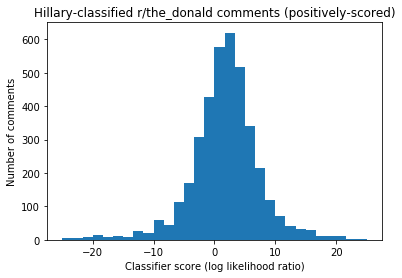

In [266]:
fig, ax=plt.subplots()
ax.set(title = "Hillary-classified r/the_donald comments (positively-scored)", xlabel = "Classifier score (log likelihood ratio)", ylabel = "Number of comments")

plt.hist(classified_donald_p, bins=30, range=[-25,25])
plt.show()

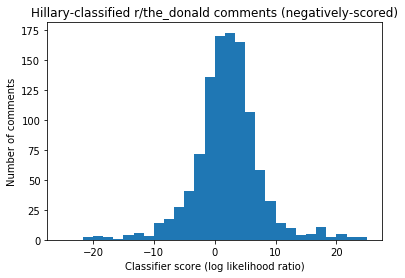

In [267]:
fig, ax=plt.subplots()
ax.set(title = "Hillary-classified r/the_donald comments (negatively-scored)", xlabel = "Classifier score (log likelihood ratio)", ylabel = "Number of comments")

plt.hist(classified_donald_n, bins=30, range=[-25,25])
plt.show()

oh god why do they look the same... is that ok? im not even sure. I know the scale is different but that doesn't really matter

In [268]:
#print(classified_donald_p.sum())
#print(classified_donald_n.sum())

print(classified_donald_p.mean())
print(classified_donald_n.mean())

1.5820830273036142
2.1381647550031193


In [269]:
#"control" subreddit - ask reddit
classified_askreddit = classify("askreddit")
classified_askreddit_p = classified_askreddit[0]
classified_askreddit_n = classified_askreddit[1]

In [270]:
print(classified_askreddit_p.mean())
print(classified_askreddit_n.mean())

3.0709298767808875
1.7299129937934947


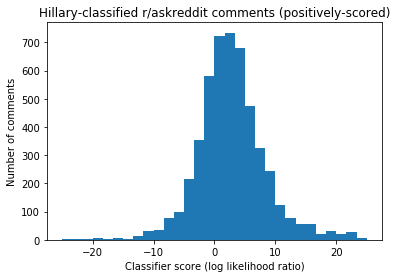

In [271]:
fig, ax=plt.subplots()
ax.set(title = "Hillary-classified r/askreddit comments (positively-scored)", xlabel = "Classifier score (log likelihood ratio)", ylabel = "Number of comments")
plt.hist(classified_askreddit_p, bins=30, range=[-25,25])
plt.show()

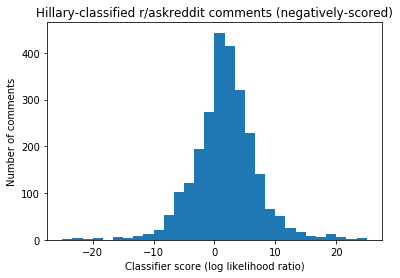

In [272]:
fig, ax=plt.subplots()
ax.set(title = "Hillary-classified r/askreddit comments (negatively-scored)", xlabel = "Classifier score (log likelihood ratio)", ylabel = "Number of comments")
plt.hist(classified_askreddit_n, bins=30, range=[-25,25])
plt.show()